In [554]:
# CPU 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nipals.NIPALS_CPU import *
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

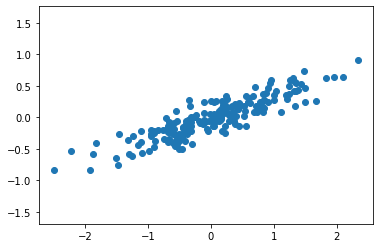

In [6]:
n_components =2

rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [7]:
X = np.random.randn(200,4)

In [8]:
std = StandardScaler()
X = std.fit_transform(X)

In [9]:
pca = PCA(n_components= n_components)
pca.fit(X)
X_pca = pca.transform(X)

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 4)
transformed shape: (200, 2)


In [10]:
nips = Nipals_cpu(ncomp= n_components)
nips.fit(X)

print('Loadings P shape : ',nips.loadings.shape)
print('Score T= U @ S shape',nips.scores.shape)

X_nips=nips.transform()
print('X transfromed shape',X_nips.shape)


Loadings P shape :  (200, 2)
Score T= U @ S shape (4, 2)
X transfromed shape (200, 2)


In [11]:
T = nips.scores
P = nips.loadings
eig = nips.eig

In [12]:
np.testing.assert_almost_equal(np.abs(X_pca),np.abs(X_nips),decimal =1)

np.testing.assert_almost_equal(eig.values,pca.singular_values_,decimal =1)

---------------

In [13]:
# PCA WITH SVD
u, s, vh = np.linalg.svd(X.T,full_matrices=False)

np.allclose(X.T,  u @ np.diag(s)@vh)

print('Loadings u : ',u.shape)
print('vh shape',vh.shape)

# Compression k=1
Z = u[:,:1].T @ X.T 
Z.shape

Loadings u :  (4, 4)
vh shape (4, 200)


(1, 200)

---

## Test Iris dataset 

In [14]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

std =StandardScaler()
X= std.fit_transform(X)

In [15]:
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

In [16]:
nips = Nipals_cpu(ncomp=n_components)
X_nips = nips.fit_transform(X)

print('Loadings P shape : ',nips.loadings.shape)
print('Score T= U @ S shape',nips.scores.shape)

Loadings P shape :  (150, 2)
Score T= U @ S shape (4, 2)


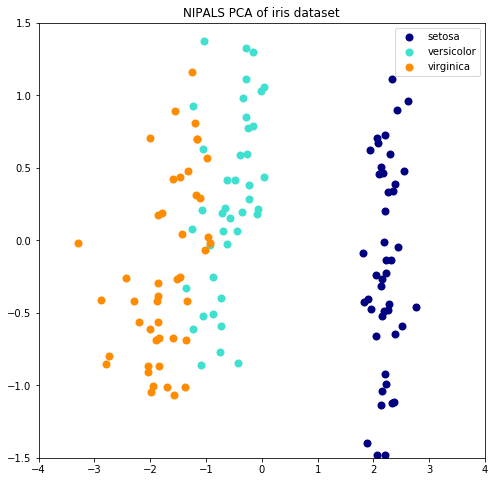

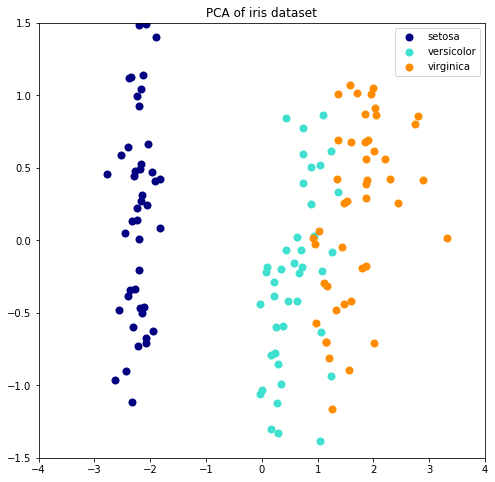

In [18]:
colors = ['navy', 'turquoise', 'darkorange']

for X_transformed, title in [(X_nips, "NIPALS PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
                    color=color, lw=2, label=target_name)

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of iris dataset\nMean absolute unsigned error "
                  "%.6f" % err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])

plt.show()

In [19]:
np.testing.assert_almost_equal(np.abs(X_pca),np.abs(X_nips),decimal =2)

## GPU implementation 

```python 
import pycuda.driver as drv


drv.init()
print("%d device(s) found." % drv.Device.count())

for ordinal in range(drv.Device.count()):
    dev = drv.Device(ordinal)
    print("Device #%d: %s" % (ordinal, dev.name()))
    print("  Compute Capability: %d.%d" % dev.compute_capability())
    print("  Total Memory: %s KB" % (dev.total_memory()//(1024)))
    atts = [(str(att), value)
            #Python 3.1 and 2.7
            for att, value in dev.get_attributes().items()]
            #Python 2.7
            #for att, value in dev.get_attributes().iteritems()]
    atts.sort()

    for att, value in atts:
        print("  %s: %s" % (att, value))

```

#### Results
* MAX_BLOCK_DIM_X: 1024
* MAX_BLOCK_DIM_Y: 1024
* MAX_BLOCK_DIM_Z: 64
* MAX_GRID_DIM_X: 2147483647
* MAX_GRID_DIM_Y: 65535
* MAX_GRID_DIM_Z: 65535
* MAX_PITCH: 2147483647
* MAX_REGISTERS_PER_BLOCK: 65536
* MAX_REGISTERS_PER_MULTIPROCESSOR: 65536
* MAX_SHARED_MEMORY_PER_BLOCK: 49152
* MAX_SHARED_MEMORY_PER_MULTIPROCESSOR: 65536
* MAX_THREADS_PER_BLOCK: 1024
* MAX_THREADS_PER_MULTIPROCESSOR: 1024
* MEMORY_CLOCK_RATE: 5001000
* MULTIPROCESSOR_COUNT: 40
* MULTI_GPU_BOARD: 0
* MULTI_GPU_BOARD_GROUP_ID: 0

##  Allocate memory 
PCA model: X = T * P’ + R

* input: X, MxN matrix (data)
* input: M = number of rows in X
* input: N = number of columns in X
* input: K = number of components (K<=N)
* X = T @ P.T ( objectif)
* output: T, MxK scores matrix
* output: P, NxK loads matrix
* output: R, MxN residual matrix


In [880]:
M = 10
N = 100 
K = 2

X = np.random.randn(M,N).astype(np.float32)
P = np.empty((N,K),dtype= np.float32)
T = np.empty((M,K),dtype= np.float32)
#R = np.empty((M,N),dtype= np.float32)
# eigenvalues 
E = np.empty((K,),dtype= np.float32)

**TODO** gérer les erreurs d'allocation de mémoire 
* Transpose data ( TODO mn be3d) 
* Center the data 


In [404]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
from pycuda import cumath
import numpy as np


M = 5
N = 3


X = np.random.randn(M,N).astype(np.float32)
th = np.random.randn(M).astype(np.float32)
ph = np.zeros((N,)).astype(np.float32)
eigh = np.zeros((1,)).astype(np.float32)

X_gpu = gpuarray.to_gpu(X)
th_gpu = gpuarray.to_gpu(th)
ph_gpu = gpuarray.to_gpu(ph)
eigh_gpu = gpuarray.to_gpu(eigh)




mod = SourceModule("""
    #define N 5
    __global__ void mult_transpose(float *X, float *th, float *ph){
        int a_idx = blockIdx.x + threadIdx.x * blockDim.y;
        
        __shared__ float temp[5]; 
        temp[threadIdx.x] =  X[a_idx] * th[threadIdx.x];
         
        __syncthreads();
        
         if (0 == threadIdx.x){ 
            float sum = 0;
            for (int i = 0; i < N; i++){
                sum += temp[i];
            }
            ph[blockIdx.x]= sum;
        }

    }
    """)

prog = mod.get_function("mult_transpose")

prog(X_gpu, th_gpu,ph_gpu,block=(M, N, 1), grid=(N, 1, 1))



print(ph_gpu)

[-2.0284014   1.7640934   0.03202835]


In [ ]:
# Multiply X.T * th

In [407]:
mod = SourceModule("""
    #include <math.h>
    #define N 3
    
    __global__ void normalize(float *ph){
    
    __shared__ float temp[N];
    
    if(0== blockIdx.x){
        temp[threadIdx.x]= ph[threadIdx.x]*ph[threadIdx.x];
    }    
    
    __syncthreads();
    
    if (0 == threadIdx.x){ 
        float sum = 0;
        for (int i = 0; i < N; i++){
            sum += temp[i];            
        }
        ph[threadIdx.y]=ph[threadIdx.y]/sqrt(sum);   
    }                     
     
    }

    """)

prog = mod.get_function("normalize")
prog(ph_gpu,block=(N,N,1), grid=(1,1,1))

In [408]:
# verify result
ph = X.T@th
ph = ph / np.sqrt(np.sum(ph*ph))
ph

array([-0.754503  ,  0.65618855,  0.01191357], dtype=float32)

In [409]:
# Multiply X * ph

In [410]:
th_old_gpu = th_gpu.copy()

mod = SourceModule("""
    #define N 3
    __global__ void mult(float *X,float *ph, float *th){                
        int idx = threadIdx.x + blockDim.x*blockIdx.x;
        
         __shared__ float temp[N]; 
        temp[threadIdx.x] =  X[idx] * ph[threadIdx.x];
         
        __syncthreads();
        
         if (0 == threadIdx.x){ 
            float sum = 0;
            for (int i = 0; i < N; i++){
                sum += temp[i];
            }
            th[blockIdx.x]= sum;
        }

    }
    """)


prog = mod.get_function("mult")

prog(X_gpu,ph_gpu,th_gpu,block=(N,1,1), grid=(M,1,1))

th_gpu

array([-0.04453373, -0.6435648 ,  0.7279924 ,  2.2491987 , -0.66640306],
      dtype=float32)

In [412]:
# verification of result 
th = X@ph
th

array([-0.04453373, -0.6435648 ,  0.7279924 ,  2.2491987 , -0.66640306],
      dtype=float32)

In [392]:
# Compute eigenvalue

In [416]:
mod = SourceModule("""
     #include <math.h>
     #define M %(size)d
        __global__ void norm2(float *th,float *eigh){                
            
        __shared__ float temp[M]; 
        
        temp[threadIdx.x] =  th[threadIdx.x] * th[threadIdx.x];
         
        __syncthreads();
        
         if (0 == threadIdx.x){ 
         
            float sum = 0;
            for (int i = 0; i < M; i++){
                sum += temp[i];
            }
            eigh[0] = sqrt(sum);
        }

    }
    """% {"size": M})

prog = mod.get_function("norm2")

prog(th_gpu,eigh_gpu,block=(M,1,1), grid=(1,1,1))

eigh_gpu

array([2.5395117], dtype=float32)

In [417]:
#verify
np.sqrt(np.sum(th*th))

2.5395117